In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
from statistical_clear_sky.configuration import CONFIG1
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from cvxpy import SolverError
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [3]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [6]:
n = 101 #np.random.randint(642)
df = load_sys(n, local=True)

FileNotFoundError: File b'../data/PVO/PVOutput/10838.csv' does not exist

In [5]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2012-08-19 2017-07-30


In [6]:
end - start

Timedelta('1806 days 00:00:00')

In [7]:
power_signals_d = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
iterative_fitting = IterativeFitting(power_signals_d, solver_type=SolverType.mosek)
iterative_fitting.fixed_time_stamps

False

obtaining weights


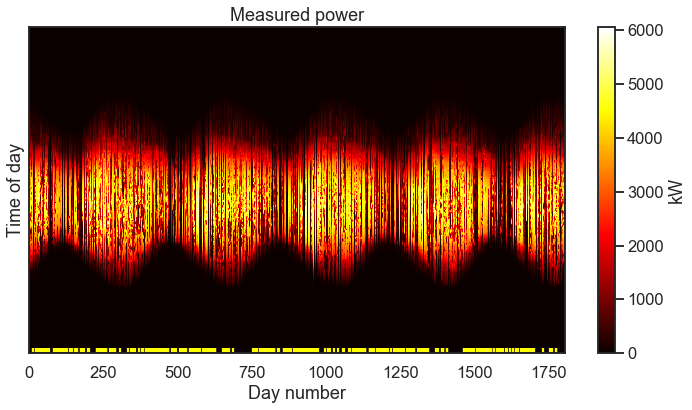

In [8]:
_ = iterative_fitting.plot_power_signals_d(show_days=True)

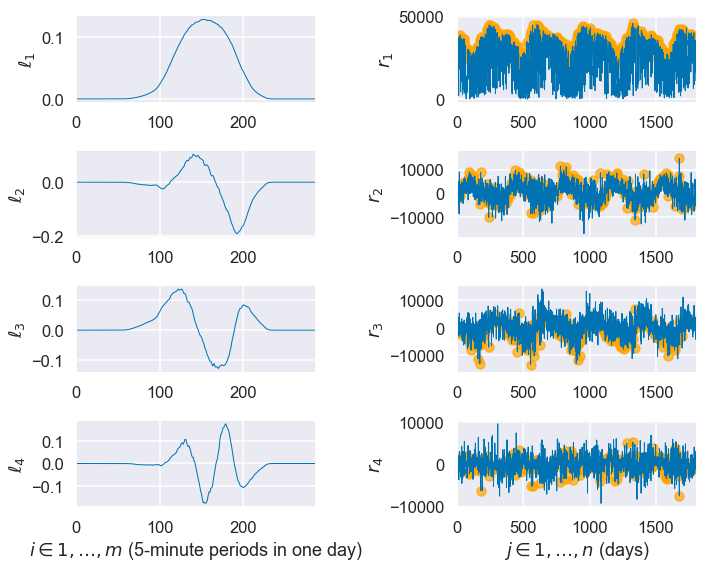

In [9]:
_ = iterative_fitting.plot_singular_vectors(show_days=True)

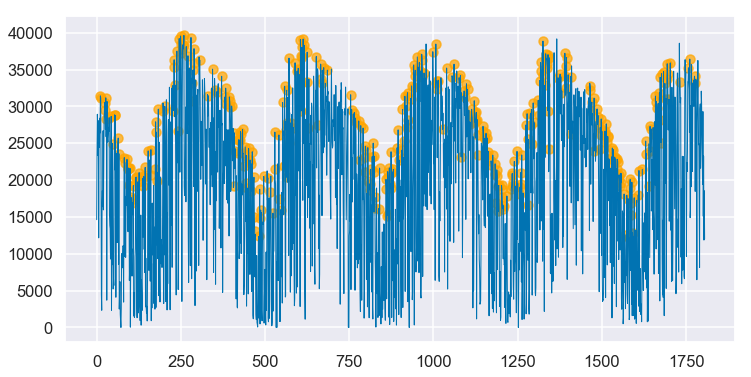

In [10]:
_ = iterative_fitting.plot_energy()

In [11]:
iterative_fitting.execute(**CONFIG1)

obtaining initial value of component r0
obtaining weights
starting at 1353178479.901 [4181341.7687035883, 509.2505773804039, 1079686621.7197156, 269310007.1619806]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 2846684.455 [2.60121487e+06 4.82508000e+02 2.44972744e+05 1.43320000e+01]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 2341682.178 [2.08014868e+06 7.52832000e+02 2.60780641e+05 2.90000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 2296689.334 [2.03697958e+06 6.64559000e+02 2.59045168e+05 2.20000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 2285381.588 [2.02943249e+06 6.52286000e+02 2.55296713e+05 9.80000000e-02]
Minimization complete in 4.61 minutes


In [12]:
print(np.round((
    iterative_fitting.residuals_median,
    iterative_fitting.residuals_variance,
    iterative_fitting.residual_l0_norm
), 3), iterative_fitting.state_data.is_problem_status_error, iterative_fitting.state_data.is_solver_error, iterative_fitting.state_data.f1_increase, iterative_fitting.state_data.obj_increase)

[0.167 0.107 0.071] False False False False


In [13]:
iterative_fitting.power_signals_d.shape[1]

1806

In [14]:
np.sum(iterative_fitting.weights > 1e-1)

402

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [15]:
iterative_fitting.beta_value

array(-0.01054483)

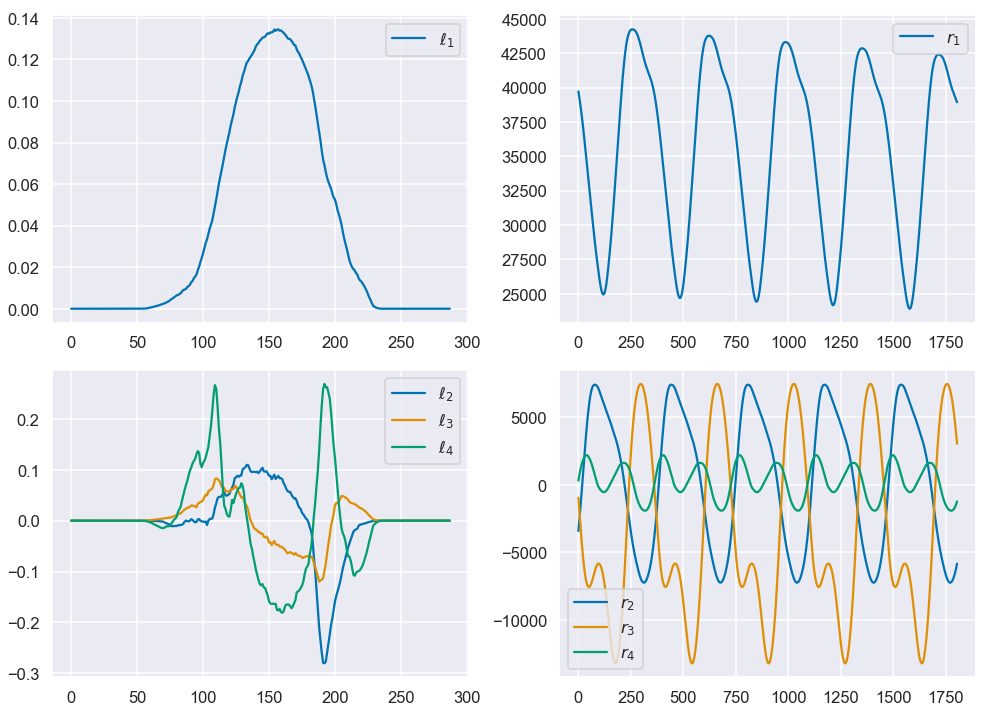

In [16]:
_ = iterative_fitting.plot_lr()

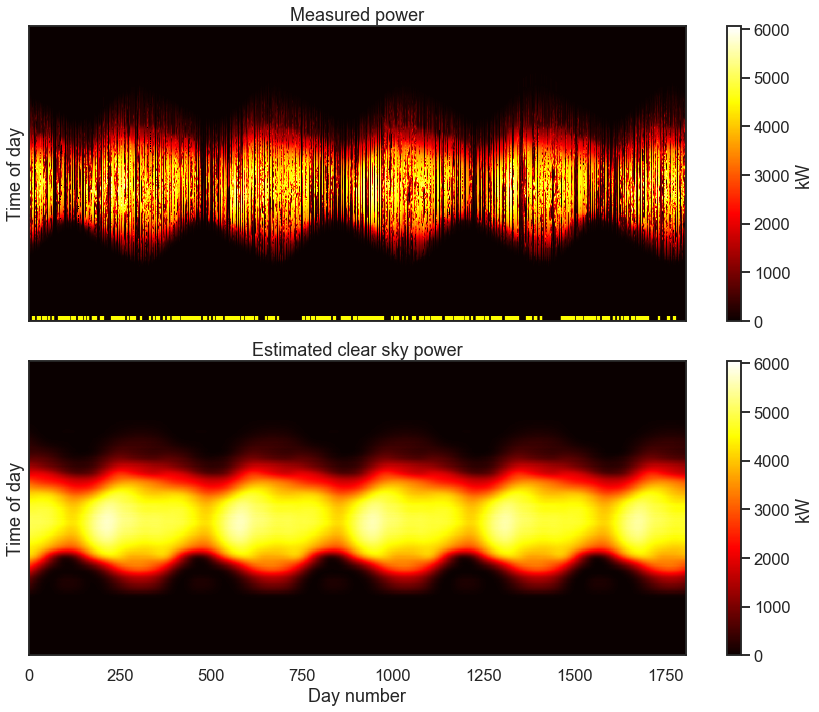

In [17]:
_ = iterative_fitting.plot_measured_clear(figsize=(12, 10), show_days=True)

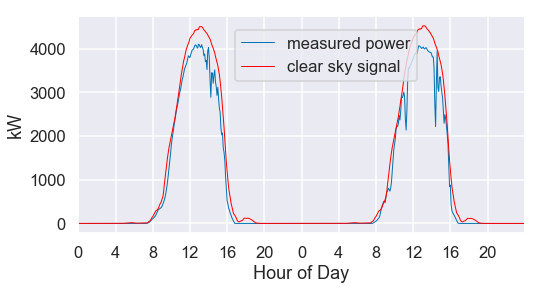

In [18]:
_ = iterative_fitting.ts_plot(139)

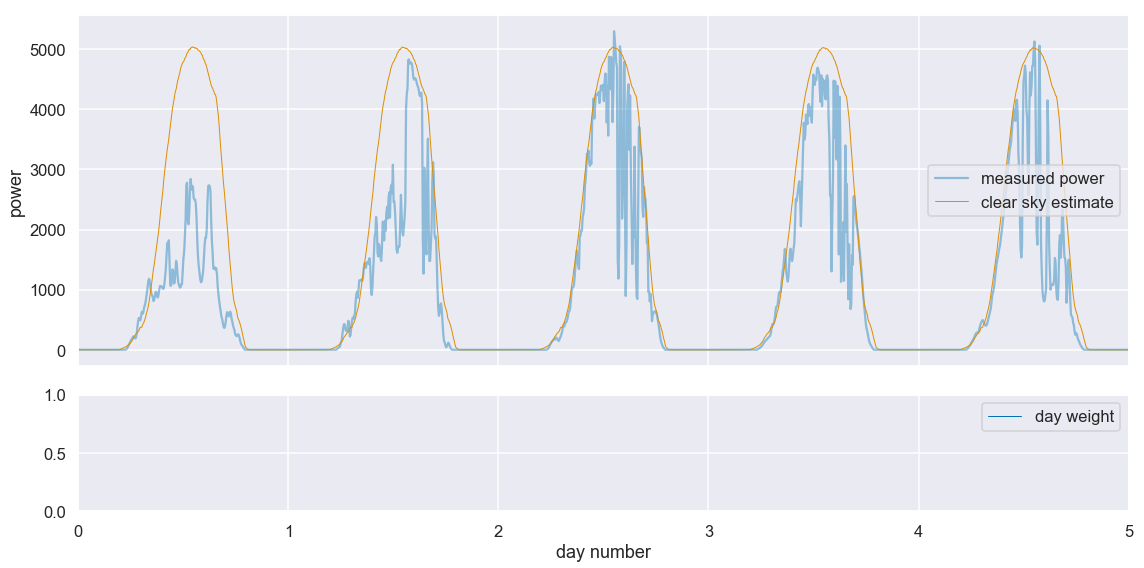

In [19]:
_ = iterative_fitting.ts_plot_with_weights(200)

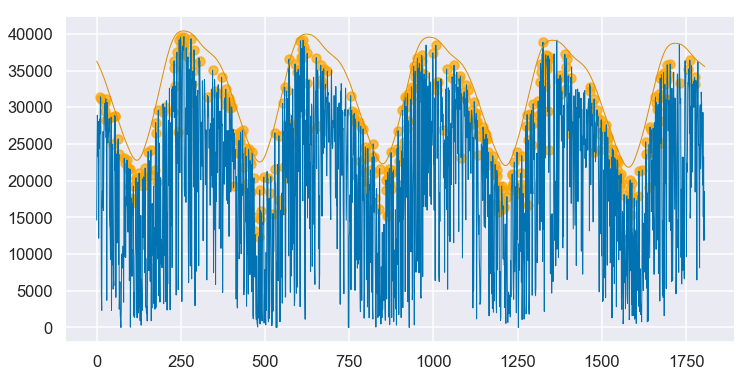

In [20]:
_ = iterative_fitting.plot_energy(show_clear=True)

## Extra notes and scratch work

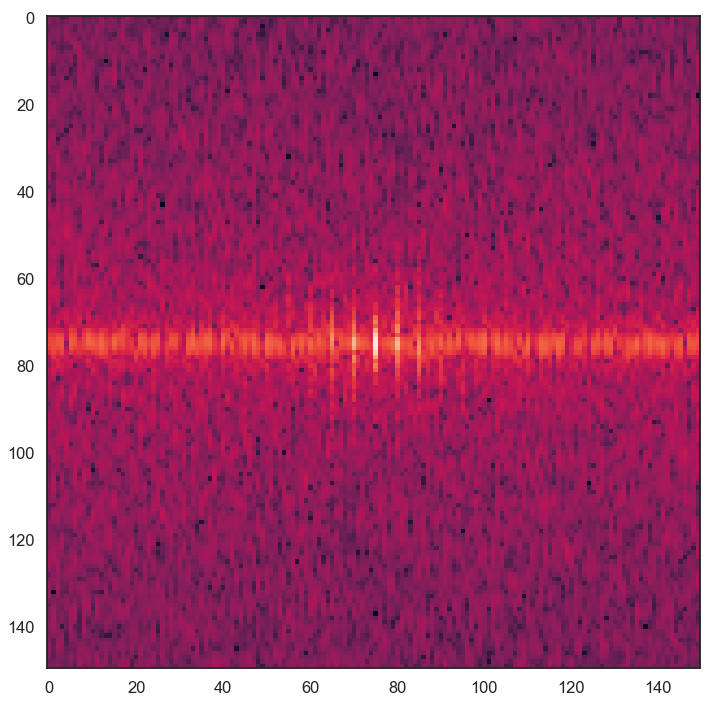

In [21]:
fs = fft2(power_signals_d)
with sns.axes_style("white"):
    m, n = power_signals_d.shape
    i = int(m / 2 - 75)
    j = int(n / 2 - 75)
    plt.figure(figsize=(12,12))
    plt.imshow(np.log(np.abs(np.fft.fftshift(fs)[i:-i, j:-j])**2))

In [22]:
fltr = np.zeros_like(power_signals_d, dtype=np.float)
m, n = power_signals_d.shape
c = (m // 2, n // 2)
r = 25
if m % 2 == 0:
    di = 0
else:
    di = 1
if n % 2 == 0:
    dj = 0
else:
    dj = 1
y, x = np.ogrid[-c[0]:c[0]+di, -c[1]:c[1]+dj]
mask = x ** 2 + y ** 2 <= r ** 2
fltr[mask] = 1
fs_filtered = fftshift(np.multiply(fftshift(fs), fltr))
power_signals_d_filtered = np.abs(ifft2(fs_filtered))

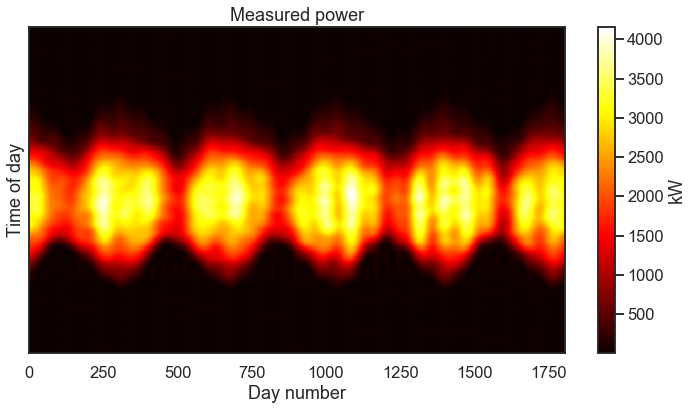

In [23]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(power_signals_d_filtered, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')